# Building and applying Generative Models using PyTorch

**Author:** [Hasib Zunair](https://hasibzunair.github.io/)<br>
**Date created:** 2024/03/20<br>
**Last modified:** 2024/06/10<br>


## 2. Finetuning a LLM to follow instructions (Instruction finetuning)

Pretrained LLMs are good at text completion, but not good at following instructions.

Here we build a model to follow instructions. Instruction finetuned models can usually perform many tasks. An example:

Convert 45 kilometers to meters (Instruction) -> 45 kilometers is 45000 meters. (Desired Response)

Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided.

In [1]:
!git clone https://github.com/rasbt/LLMs-from-scratch
%cd LLMs-from-scratch/ch07/01_main-chapter-code/

Cloning into 'LLMs-from-scratch'...
remote: Enumerating objects: 3452, done.
remote: Counting objects: 100% (994/994), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 3452 (delta 835), reused 834 (delta 766), pack-reused 2458
Receiving objects: 100% (3452/3452), 9.60 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (2161/2161), done.
/content/LLMs-from-scratch/ch07/01_main-chapter-code


In [2]:
from importlib.metadata import version

!pip install tiktoken
!pip install tensorflow==2.15.0

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00
matplotlib version: 3.7.1
numpy version: 1.25.2
tiktoken version: 0.7.0
torch version: 2.3.0+cu121
tensorflow version: 2.15.0
pandas version: 2.0.3


### Prepare dataset

Download the instruction dataset. It consists of instruction, input and output text pairs.

In [3]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form:

In [4]:
print("Example entry:\n\n", data[50])

Example entry:

 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example entry:\n\n", data[999])

Another example entry:

 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


We use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning. For more details, see https://crfm.stanford.edu/2023/03/13/alpaca.html.


In [6]:
# format the input that we will pass as input to the LLM
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
# A formatted response with input field looks like as shown below
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
# Below is a formatted response without input field
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [9]:
# Split to train, val and test
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)   # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Create data loaders

In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [13]:
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [14]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []
    for item in batch:
        # Add an <|endoftext|> token
        item += [pad_token_id]
        # Pad sequences to max_length
        padded = item + [pad_token_id] * (batch_max_length - len(item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(custom_collate_fn, device=device)

Device: cuda


In [16]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False
)

In [17]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [18]:
for i in x[0]:
    print(i.item(), end=", ")

21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 30003, 6525, 262, 6827, 1262, 257, 985, 576, 13, 198, 198, 21017, 23412, 25, 198, 464, 5156, 318, 845, 13779, 13, 198, 198, 21017, 18261, 25, 198, 464, 5156, 318, 355, 13779, 355, 257, 4936, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [19]:
for i in y[0]:
    print(i.item(), end=", ")

318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 30003, 6525, 262, 6827, 1262, 257, 985, 576, 13, 198, 198, 21017, 23412, 25, 198, 464, 5156, 318, 845, 13779, 13, 198, 198, 21017, 18261, 25, 198, 464, 5156, 318, 355, 13779, 355, 257, 4936, 13, 50256, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

### Initialize a LLM with pretrained weights

In [20]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 53.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 575kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 60.6kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:08<00:00, 7.27MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.30MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 335kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 326kiB/s]


To ensure that the model was loaded corrected, let's double-check that it generates coherent text.

In [22]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [23]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [24]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


We can see that the model is not good off-the-shelf.

### Finetuning the LLM on instruction data

In [25]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

Using the `calc_closs_loader`, we compute the initial training, validation, and test set losses before we start training.

In [26]:
model.to(device)

torch.manual_seed(123)  # For reproducibility due to the shuffling in the data loader

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.167139339447021
Validation loss: 4.050935745239258


In [ ]:
# takes a while to run on CPU

import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 5

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.119, Val loss 3.069
Ep 1 (Step 000005): Train loss 1.696, Val loss 1.570
Ep 1 (Step 000010): Train loss 1.096, Val loss 1.164
Ep 1 (Step 000015): Train loss 1.053, Val loss 1.083
Ep 1 (Step 000020): Train loss 0.970, Val loss 1.038
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.002
Ep 1 (Step 000030): Train loss 0.960, Val loss 0.978
Ep 1 (Step 000035): Train loss 0.878, Val loss 0.951
Ep 1 (Step 000040): Train loss 0.847, Val loss 0.943
Ep 1 (Step 000045): Train loss 0.777, Val loss 0.925
Ep 1 (Step 000050): Train loss 0.869, Val loss 0.911
Ep 1 (Step 000055): Train loss 0.924, Val loss 0.893
Ep 1 (Step 000060): Train loss 0.873, Val loss 0.878
Ep 1 (Step 000065): Train loss 0.800, Val loss 0.867
Ep 1 (Step 000070): Train loss 0.694, Val loss 0.860
Ep 1 (Step 000075): Train loss 0.706, Val loss 0.856
Ep 1 (Step 000080): Train loss 0.753, Val loss 0.847
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.836
Ep 1 (Step 000090): Train loss 0.729, Val loss

In [ ]:
# Save the model in case we want to reuse the model later
torch.save(model.state_dict(), "instruct_model.pth")

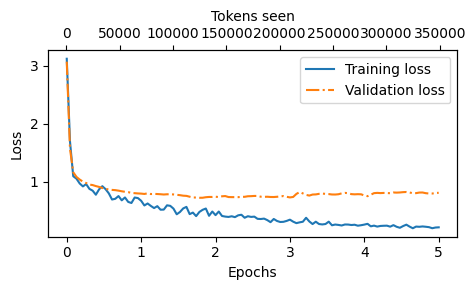

In [ ]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Using the LLM to follow instructions

Let's use the finetuned GPT model in action.

In [ ]:
# Load the newly trained model

# when using server
model_state_dict = torch.load("../../../instruct_model.pth", map_location=device)
# when using colab
#model_state_dict = torch.load("instruct_model.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### Run instruction model on test dataset and extract responses

In [ ]:
def extract_response(response):
    return response[response.find("\n### Response")+len("\n### Response:")+1:]

In [ ]:
torch.manual_seed(123)

# last three samples from test dataset
for entry in test_data[-3:]:

    # prepare input
    input_text = format_input(entry)

    # run inference
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    # post process output
    response = token_ids_to_text(token_ids, tokenizer)
    response_text = extract_response(response)

    # print output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify each sentence as either declarative, interrogative, imperative, or exclamatory.

### Input:
Please open the door.

Correct response:
>> The classification of the sentence 'Please open the door.' is imperative.

Model response:
>> Clarity is a function of time.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence to use a negative adverb.

### Input:
She always remembers to call.

Correct response:
>> She never forgets to call.

Model response:
>> She always calls.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 50 miles per hour to kilometers per hour.

Correct response:
>> 50 miles per hour is approximately

### Run instruction model on custom inputs

In [ ]:
def run_instruction_model(instruction_text, input_text):

  # prepare inputs
  input_text = format_input({'instruction': instruction_text, 'input': input_text})

  # model inference
  token_ids = generate(
      model=model,
      idx=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256
  )

  # post process output
  response = token_ids_to_text(token_ids, tokenizer)
  response_text = extract_response(response)

  # print output and return the output
  print(input_text)
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")
  return response_text.strip()

In [ ]:
instruction = "Rewrite the sentence using a simile."
input = "The car is very fast."

output_text = run_instruction_model(instruction, input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------


In [ ]:
instruction_2 = "Is the following text a spam?"
input_2 = "You are a winner you have been specially selected to receive $1000 cash or a $2000 award."

output_text2 = run_instruction_model(instruction_2, input_2)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Is the following text a spam?

### Input:
You are a winner you have been specially selected to receive $1000 cash or a $2000 award.

Model response:
>> The text was a spam.
-------------------------------------


In [ ]:
instruction_3 = "Translate into French."
input_3 = "Hello, How are you?"

output_text3 = run_instruction_model(instruction_3, input_3)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Translate into French.

### Input:
Hello, How are you?

Model response:
>> I am in France.
-------------------------------------


In [ ]:
instruction_4 = "Convert 3 meters to centimeters."
input_4 = ""

output_text3 = run_instruction_model(instruction_4, input_4)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 3 meters to centimeters.

Model response:
>> 3 meters is 300 centimeters.
-------------------------------------


In [ ]:
# cleanup
!rm -rf /home/haszun/june-20/LLMs-from-scratch/

## 3. Learning resources
* [Intro to Large Language Models](https://youtu.be/zjkBMFhNj_g?si=bIVqXiQratJdqvhj)
* [Understanding Large Language Models](https://magazine.sebastianraschka.com/p/understanding-large-language-models)
* [QLoRA is all you need (Fast and lightweight model fine-tuning)](https://youtu.be/J_3hDqSvpmg?si=b0j8O2puV42z18UL)
* [Parameter-efficient Finetuning with LoRA](https://github.com/rasbt/LLMs-from-scratch/blob/main/appendix-E/01_main-chapter-code/appendix-E.ipynb)
* [QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)
* [Run Mixtral-8x7B models in Colab or consumer desktops](https://github.com/dvmazur/mixtral-offloading)

### Acknowledgements

This repository was built using [Implementing a ChatGPT-like LLM in PyTorch from scratch, step by step](https://github.com/rasbt/LLMs-from-scratch).

In [ ]:
print("The End.")

The End.
